In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn import manifold
import numpy as np
import random

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
class RBL(nn.Module):

    def __init__(self, ch_in, ch_out, stride=1):
        super(RBL, self).__init__()
        self.c1 = nn.Conv2d(
            ch_in, ch_out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.normalize1 = nn.BatchNorm2d(ch_out)
        self.c2 = nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=False)
        self.normalize2 = nn.BatchNorm2d(ch_out)

        self.skip_c = nn.Sequential()
        if stride != 1 or ch_in != ch_out:
            self.skip_c = nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(ch_out)
            )
    def forward(self, x):
        fo = self.c1(x)
        fo = self.normalize1(fo)
        fo = F.relu(fo)
        fo = self.c2(fo)
        fo = self.normalize2(fo)
        fo += self.skip_c(x)
        fo = F.relu(fo)
        return fo

In [4]:
class RN_lite(nn.Module):
    def __init__(self, ch, bc, num_categories=10):
        super(RN_lite, self).__init__()
        self.ch_in = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.normalize1 = nn.BatchNorm2d(16)
        self.Lf = self._make_layer(ch, 16, bc[0], stride=1)
        self.Ls = self._make_layer(ch, 32, bc[1], stride=2)
        self.Lth = self._make_layer(ch, 64, bc[2], stride=2)
        self.polling = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(64, num_categories)

    def _make_layer(self, ch, ch_out, bc, stride):
        strides = [stride] + [1]*(bc-1)
        layers = []
        for stride in strides:
            layers.append(ch(self.ch_in, ch_out, stride))
            self.ch_in = ch_out
        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.normalize1(x)
        x = F.relu(x)
        x = self.Lf(x)
        x = self.Ls(x)
        x = self.Lth(x)
        x = self.polling(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
layers=[1, 1, 1, 1]
m1 = RN_lite(RBL, layers).to(device)
summary(m1, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
               RBL-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 32, 16, 16]           4,608
       BatchNorm2d-9           [-1, 32, 16, 16]              64
           Conv2d-10           [-1, 32, 16, 16]           9,216
      BatchNorm2d-11           [-1, 32, 16, 16]              64
           Conv2d-12           [-1, 32, 16, 16]             512
      BatchNorm2d-13           [-1, 32, 16, 16]              64
              RBL-14           [-1, 32,

In [5]:
class RN_improved(nn.Module):
    def __init__(self, ch, bc, num_categories=10):
        super(RN_improved, self).__init__()
        self.ch_in = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.normalize1 = nn.BatchNorm2d(64)
        self.Lf = self._make_layer(ch, 64, bc[0], stride=1)
        self.Ls = self._make_layer(ch, 128, bc[1], stride=2)
        self.Lth = self._make_layer(ch, 256, bc[2], stride=2)
        self.Lfr = self._make_layer(ch, 512, bc[2], stride=2)
        self.polling = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, num_categories)

    def _make_layer(self, ch, ch_out, bc, stride):
        strides = [stride] + [1]*(bc-1)
        layers = []
        for stride in strides:
            layers.append(ch(self.ch_in, ch_out, stride))
            self.ch_in = ch_out
        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.normalize1(x)
        x = F.relu(x)
        x = self.Lf(x)
        x = self.Ls(x)
        x = self.Lth(x)
        x = self.Lfr(x)
        x = self.polling(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
m2 = RN_improved(RBL, layers).to(device)
summary(m2, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
               RBL-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 16, 16]          73,728
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
           Conv2d-12          [-1, 128, 16, 16]           8,192
      BatchNorm2d-13          [-1, 128, 16, 16]             256
              RBL-14          [-1, 128,

In [6]:
# create dataset with data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])
test_transform = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], 
                                                std = [0.2023, 0.1994, 0.2010])
                       ])
ds_tr = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
ds_ts = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
ld_tr = torch.utils.data.DataLoader(ds_tr, batch_size=64, shuffle=True, num_workers=4)
ld_ts = torch.utils.data.DataLoader(ds_ts, batch_size=64, shuffle=False, num_workers=4)

100%|██████████| 170498071/170498071 [00:04<00:00, 41794717.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


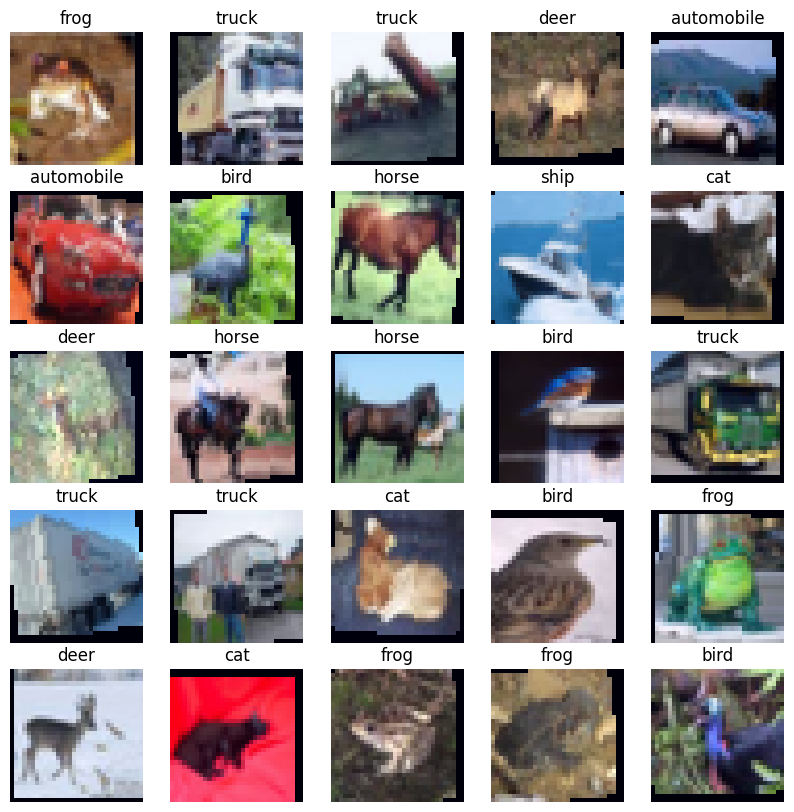

In [7]:
def plot_imgs(imgs, labels, categories, normalize = False):
    n_imgs = len(imgs)
    rows = int(np.sqrt(n_imgs))
    cols = int(np.sqrt(n_imgs))
    fig = plt.figure(figsize = (10, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)       
        image = imgs[i]
        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(categories[labels[i]])
        ax.axis('off')

N_imgs = 25
imgs, labels = zip(*[(image, label) for image, label in [ds_tr[i] for i in range(N_imgs)]])
categories = ds_ts.classes
plot_imgs(imgs, labels, categories, normalize = True)

In [8]:
def func_tr(data_loader, model, LossFunc, optimizer, lrScheduler = None):
    lr_tck = {}
    accurate_pred_count = 0
    record_loss = 0.0
    model.train()
    for i, (imgs, labels) in enumerate(data_loader):
        lr_tck[i] = optimizer.param_groups[0]['lr']
        
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = LossFunc(y_hat, labels) 
        record_loss += loss.item()
        pred = torch.max(y_hat.data, 1)[1]
        accurate_pred_count += (pred == labels).sum().item()
        
        loss.backward()
        optimizer.step()
        if lrScheduler:
            lrScheduler.step()

    
    return accurate_pred_count , record_loss, lr_tck
    
def evaluate(data_loader, model, LossFunc):
    accurate_pred_count = 0
    record_loss = 0.0
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            y_hat = model(imgs)
            loss = LossFunc(y_hat, labels) 
            record_loss += loss.item()
            _, pred = torch.max(y_hat, 1)
            accurate_pred_count += (pred == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
    
    return accurate_pred_count, record_loss, y_true, y_pred

In [9]:
lr_end = 8*1e-5
lr_start = 1e-2
n_epochs = 40
step_size = (len(ds_tr)/64) // 2

model = m1
LossFunc = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr_end, momentum=0.9, nesterov=True)
lrScheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr_end, max_lr=lr_start, step_size_up=step_size, step_size_down=step_size, gamma=0.9999, mode="exp_range", cycle_momentum=False)
LearningRates_t = {}

l_tr_lite = []
acc_tr_lite = []
l_va_lite = []
acc_va_lite = []
y_pred_lite = []
y_true_lite = []
lowest_L = float('inf')

for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}/{n_epochs}")
    pred_success, loss, LearningRates = func_tr(data_loader=ld_tr, model=model, LossFunc=LossFunc, optimizer=optimizer, lrScheduler=lrScheduler)
    acc = pred_success / len(ld_tr.dataset)
    avg_loss = loss / len(ld_tr)
    train_loss = avg_loss
    acc_tr_lite.append(acc)
    l_tr_lite.append(avg_loss)
    for key in LearningRates.keys():
        LearningRates_t[(epoch,key)] = LearningRates[key]
    pred_success, loss, y_true_lite, y_pred_lite = evaluate(data_loader = ld_ts, model=model, LossFunc=LossFunc)
    validation_acc = pred_success / len(ld_ts.dataset)
    validation_loss = loss / len(ld_ts)
    print(f"Train acc: {acc*100:.4f}%, \nTrain loss: {train_loss}")
    print(f"Test acc: {validation_acc*100:.4f}%, \nTest loss: {validation_loss}")
    if validation_loss < lowest_L:
        lowest_L = validation_loss
        torch.save(model.state_dict(), 'RN_lite.pt')
    acc_va_lite.append(validation_acc)
    l_va_lite.append(validation_loss)

Epoch: 1/40
Train acc: 36.8920%, 
Train loss: 1.693355707408827
Test acc: 51.0300%, 
Test loss: 1.3275996530131928
Epoch: 2/40
Train acc: 52.7860%, 
Train loss: 1.2966807662221171
Test acc: 60.3000%, 
Test loss: 1.0909508603393652
Epoch: 3/40
Train acc: 59.5160%, 
Train loss: 1.1300350400188086
Test acc: 64.1000%, 
Test loss: 0.98426959355166
Epoch: 4/40
Train acc: 62.8240%, 
Train loss: 1.039014108574299
Test acc: 67.5200%, 
Test loss: 0.9113140516220384
Epoch: 5/40
Train acc: 65.0940%, 
Train loss: 0.9811291356983087
Test acc: 68.9900%, 
Test loss: 0.8659429793145247
Epoch: 6/40
Train acc: 66.8920%, 
Train loss: 0.9320340305947892
Test acc: 69.9600%, 
Test loss: 0.8396706417867332
Epoch: 7/40
Train acc: 67.8740%, 
Train loss: 0.901046511614719
Test acc: 70.9600%, 
Test loss: 0.8085467325654
Epoch: 8/40
Train acc: 69.2460%, 
Train loss: 0.8641930201931682
Test acc: 72.5800%, 
Test loss: 0.7758005832790569
Epoch: 9/40
Train acc: 70.4080%, 
Train loss: 0.8428415364545324
Test acc: 73.33

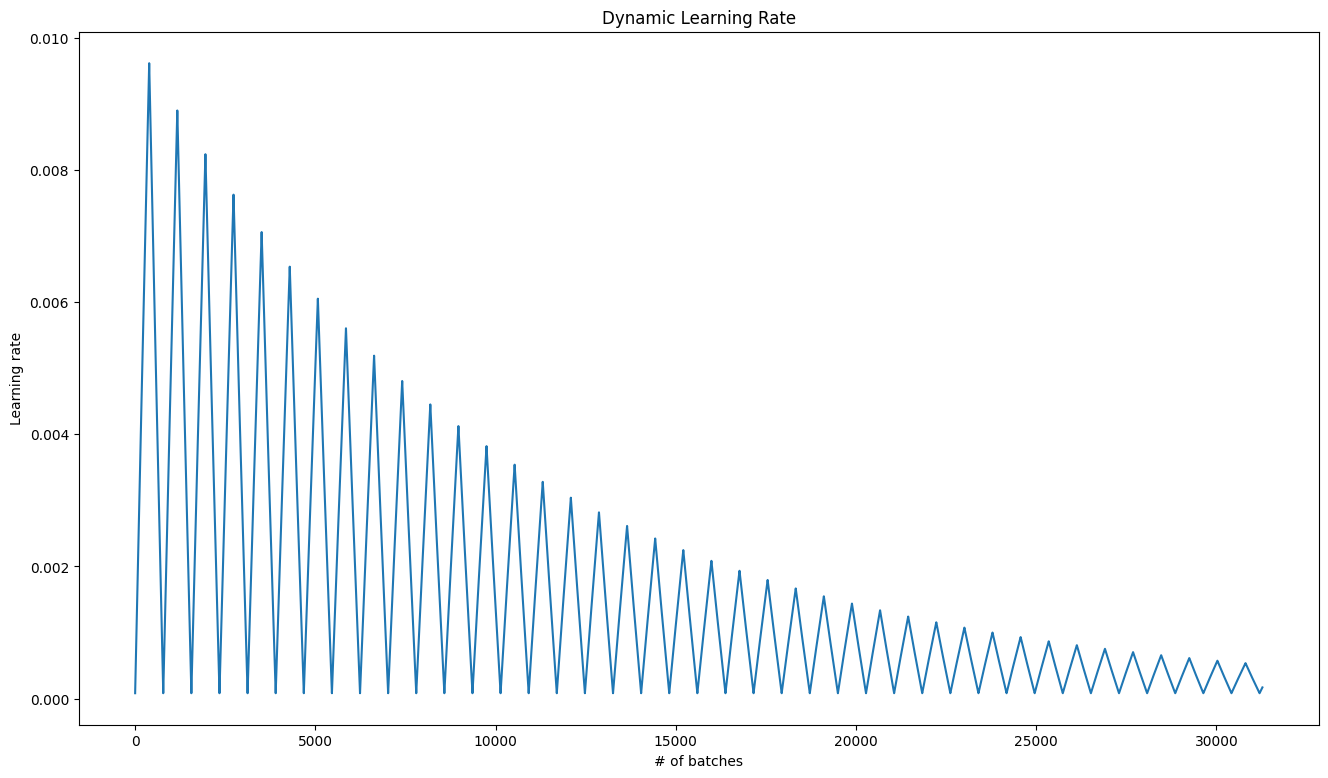

In [15]:
fig, ax = plt.subplots(figsize=(16,9))
plt.title('Dynamic Learning Rate')
plt.plot(range(len(LearningRates_t)), LearningRates_t.values())
plt.xlabel('# of batches')
plt.ylabel('Learning rate')
plt.show()

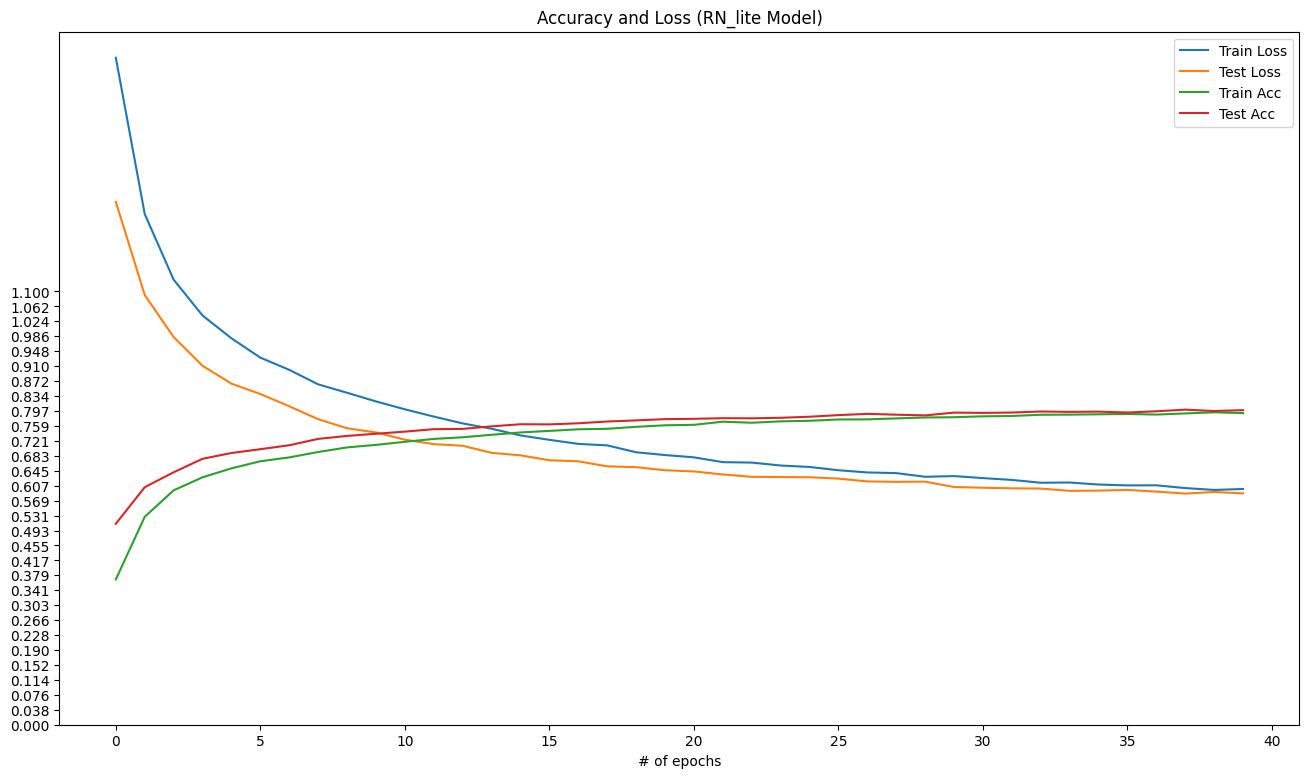

In [16]:
fig, ax = plt.subplots(figsize=(16,9))

plt.title('Accuracy and Loss (RN_lite Model)')
plt.plot(l_tr_lite, label='Train Loss')
plt.plot(l_va_lite, label='Test Loss')
plt.plot(acc_tr_lite, label='Train Acc')  
plt.plot(acc_va_lite, label='Test Acc')
plt.legend()
plt.xlabel("# of epochs")
yticks = np.linspace(0, 1.1, num=30)
ax.set_yticks(yticks)
plt.show()  

In [13]:
lr_end = 8*1e-5
lr_start = 1e-2
n_epochs = 40
step_size = (len(ds_tr)/64) // 2

model = m2
LossFunc = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr_end, momentum=0.9, nesterov=True)
lrScheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr_end, max_lr=lr_start, step_size_up=step_size, step_size_down=step_size, gamma=0.9999, mode="exp_range", cycle_momentum=False)
LearningRates_t = {}

l_tr_Improv = []
acc_tr_Improv = []
l_va_Improv = []
acc_va_Improv = []
y_pred_Improv = []
y_true_Improv = []
lowest_L = float('inf')

for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}/{n_epochs}")
    pred_success, loss, LearningRates = func_tr(data_loader=ld_tr, model=model, LossFunc=LossFunc, optimizer=optimizer, lrScheduler=lrScheduler)
    acc = pred_success / len(ld_tr.dataset)
    loss = loss / len(ld_tr)
    train_loss = loss
    acc_tr_Improv.append(acc)
    l_tr_Improv.append(loss)
    for key in LearningRates.keys():
        LearningRates_t[(epoch,key)] = LearningRates[key]
    pred_success, loss, y_true_large, y_pred_large = evaluate(data_loader = ld_ts, model=model, LossFunc=LossFunc)
    validation_acc = pred_success / len(ld_ts.dataset)
    validation_loss = loss / len(ld_ts)
    print(f"Train acc: {acc*100:.4f}%, \nTrain Loss: {train_loss}")
    print(f"Test acc: {validation_acc*100:.4f}%, \nTest Loss: {validation_loss}")
    if validation_loss < lowest_L:
        lowest_L = validation_loss
        torch.save(model.state_dict(), 'RN_improved.pt')
    acc_va_Improv.append(validation_acc)
    l_va_Improv.append(validation_loss)

Epoch: 1/40
Train acc: 48.7080%, 
Train Loss: 1.4096270064106378
Test acc: 66.4000%, 
Test Loss: 0.9374247478072051
Epoch: 2/40
Train acc: 65.1580%, 
Train Loss: 0.9800059651322377
Test acc: 72.8000%, 
Test Loss: 0.7652575747602305
Epoch: 3/40
Train acc: 70.8560%, 
Train Loss: 0.8292792039301694
Test acc: 76.6700%, 
Test Loss: 0.6633698492293145
Epoch: 4/40
Train acc: 74.6340%, 
Train Loss: 0.721870159477834
Test acc: 79.2700%, 
Test Loss: 0.5946964082444549
Epoch: 5/40
Train acc: 77.4700%, 
Train Loss: 0.6470185436327439
Test acc: 80.8300%, 
Test Loss: 0.5470173005845137
Epoch: 6/40
Train acc: 79.4120%, 
Train Loss: 0.5898652202866571
Test acc: 82.6200%, 
Test Loss: 0.5015018328929403
Epoch: 7/40
Train acc: 81.0060%, 
Train Loss: 0.5440486833796172
Test acc: 83.5900%, 
Test Loss: 0.4735033148603075
Epoch: 8/40
Train acc: 82.4700%, 
Train Loss: 0.5060917288255509
Test acc: 84.6800%, 
Test Loss: 0.44763072973983303
Epoch: 9/40
Train acc: 83.5840%, 
Train Loss: 0.4740287006625434
Test ac

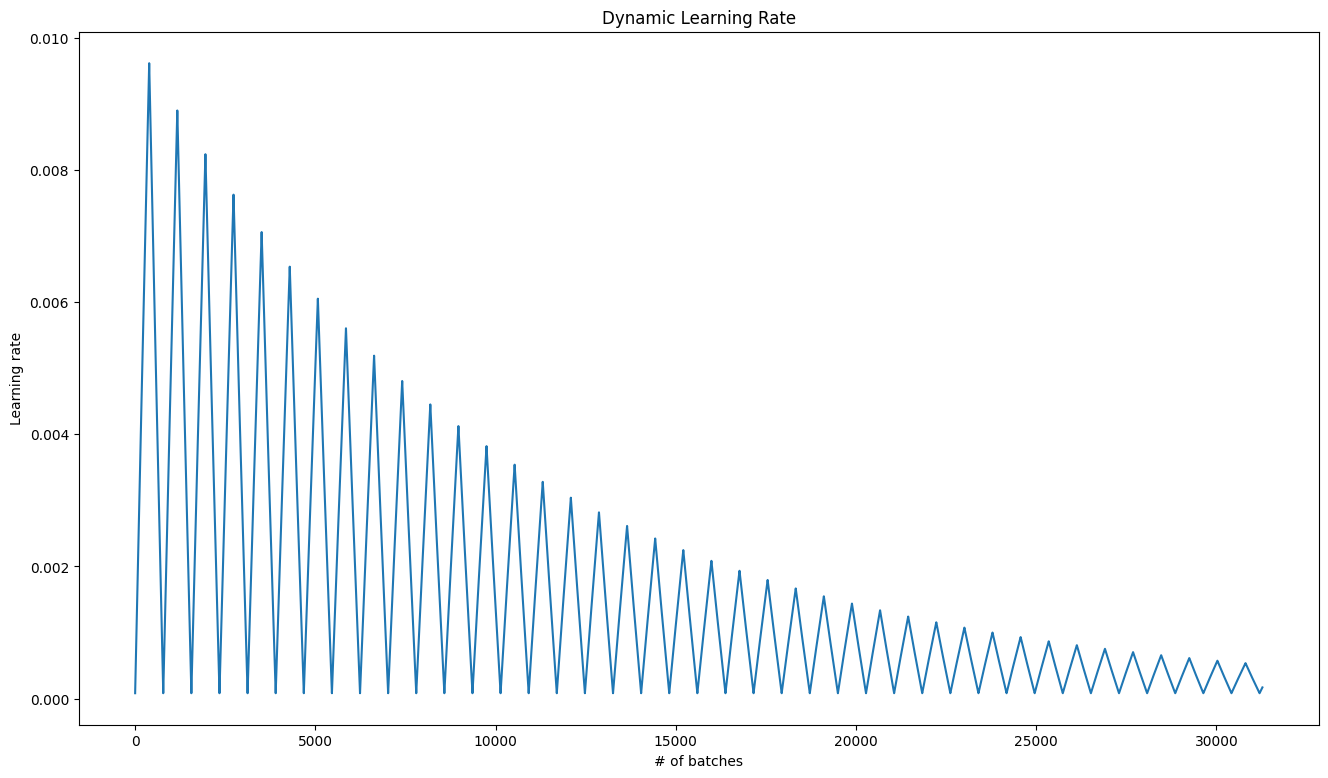

In [17]:
fig, ax = plt.subplots(figsize=(16,9))
plt.title('Dynamic Learning Rate')
plt.plot(range(len(LearningRates_t)), LearningRates_t.values())
plt.xlabel('# of batches')
plt.ylabel('Learning rate')
plt.show()

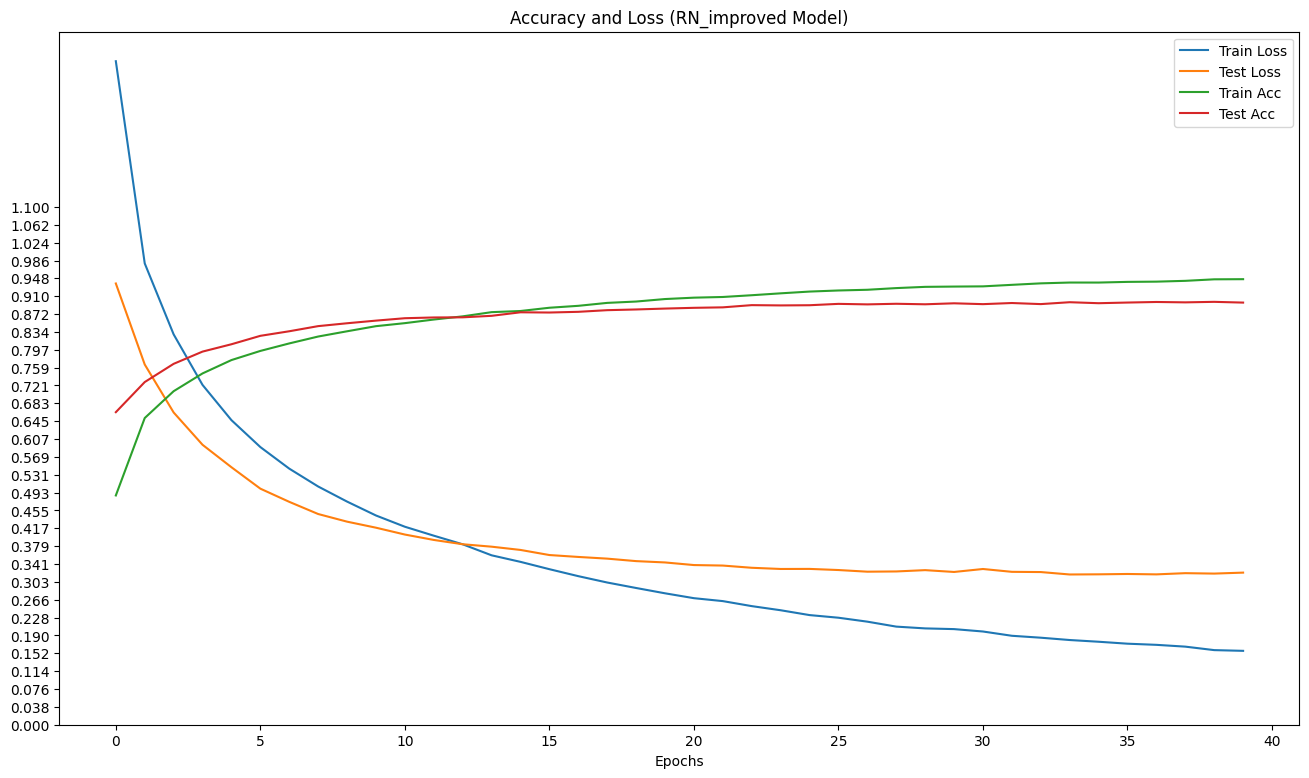

In [18]:
fig, ax = plt.subplots(figsize=(16,9))

plt.title('Accuracy and Loss (RN_improved Model)')
plt.plot(l_tr_Improv, label='Train Loss')
plt.plot(l_va_Improv, label='Test Loss')
plt.plot(acc_tr_Improv, label='Train Acc')  
plt.plot(acc_va_Improv, label='Test Acc')
plt.legend()
plt.xlabel("Epochs")
yticks = np.linspace(0, 1.1, num=30)
ax.set_yticks(yticks)
plt.show()  

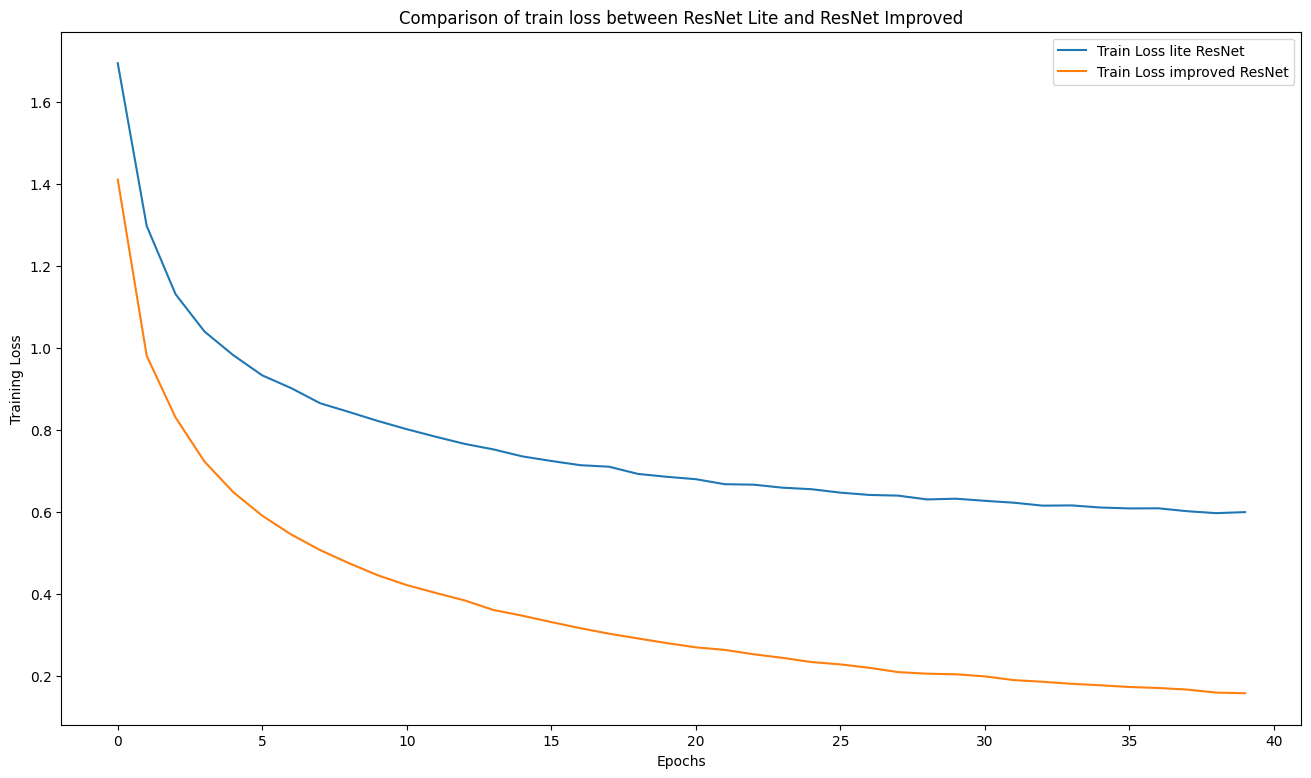

In [20]:
fig, ax = plt.subplots(figsize=(16,9))
plt.title('Comparison of train loss between ResNet Lite and ResNet Improved')
plt.plot(l_tr_lite, label='Train Loss lite ResNet')
plt.plot(l_tr_Improv, label='Train Loss improved ResNet')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()  

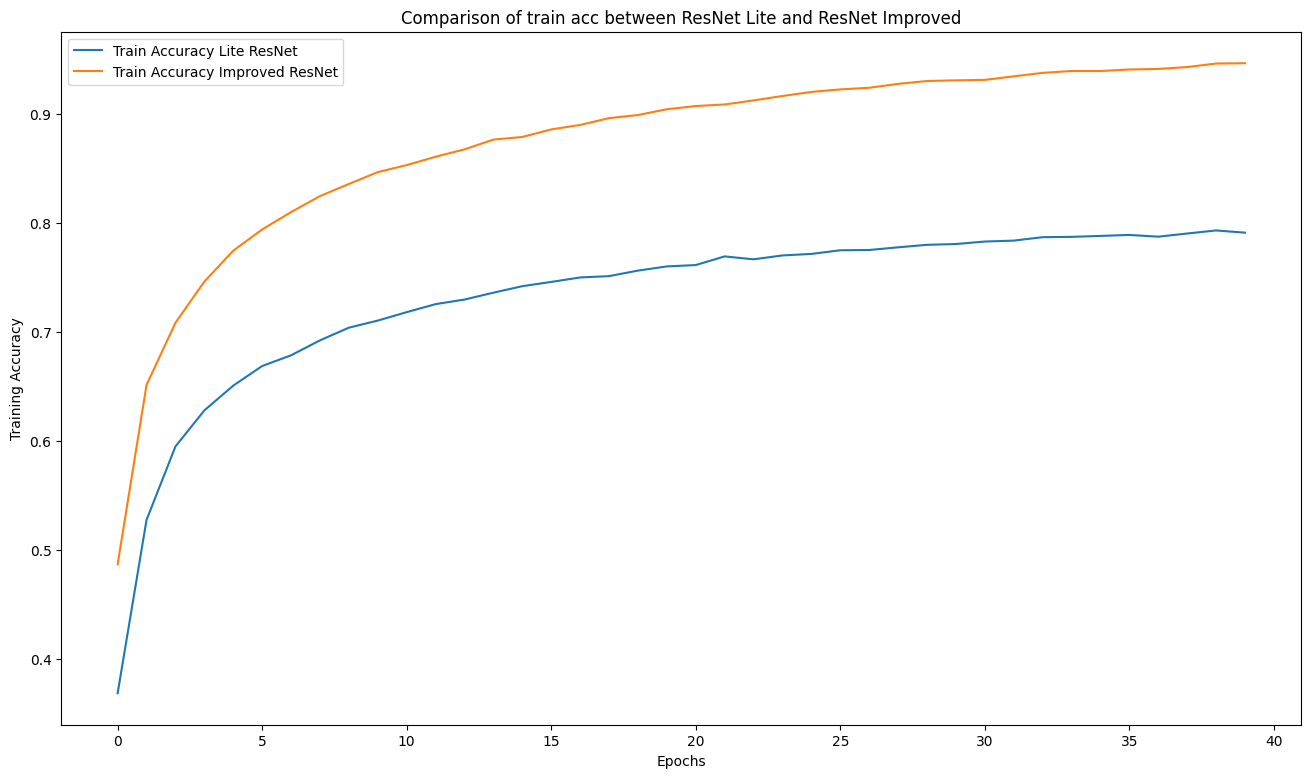

In [21]:
fig, ax = plt.subplots(figsize=(16,9))
plt.title('Comparison of train acc between ResNet Lite and ResNet Improved')
plt.plot(acc_tr_lite, label='Train Accuracy Lite ResNet')
plt.plot(acc_tr_Improv, label='Train Accuracy Improved ResNet')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.show()

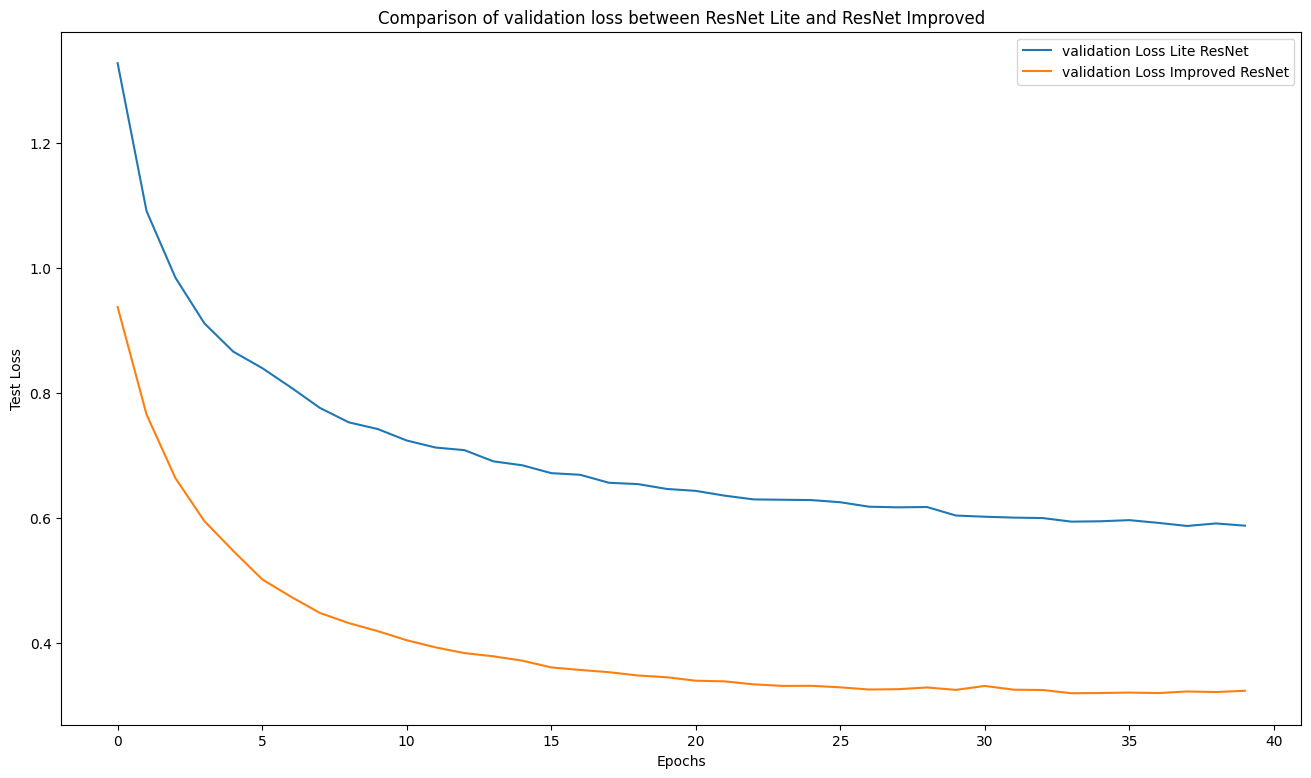

In [22]:
fig, ax = plt.subplots(figsize=(16,9))
plt.title('Comparison of validation loss between ResNet Lite and ResNet Improved')
plt.plot(l_va_lite, label='validation Loss Lite ResNet')
plt.plot(l_va_Improv, label='validation Loss Improved ResNet')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Test Loss")
plt.show()

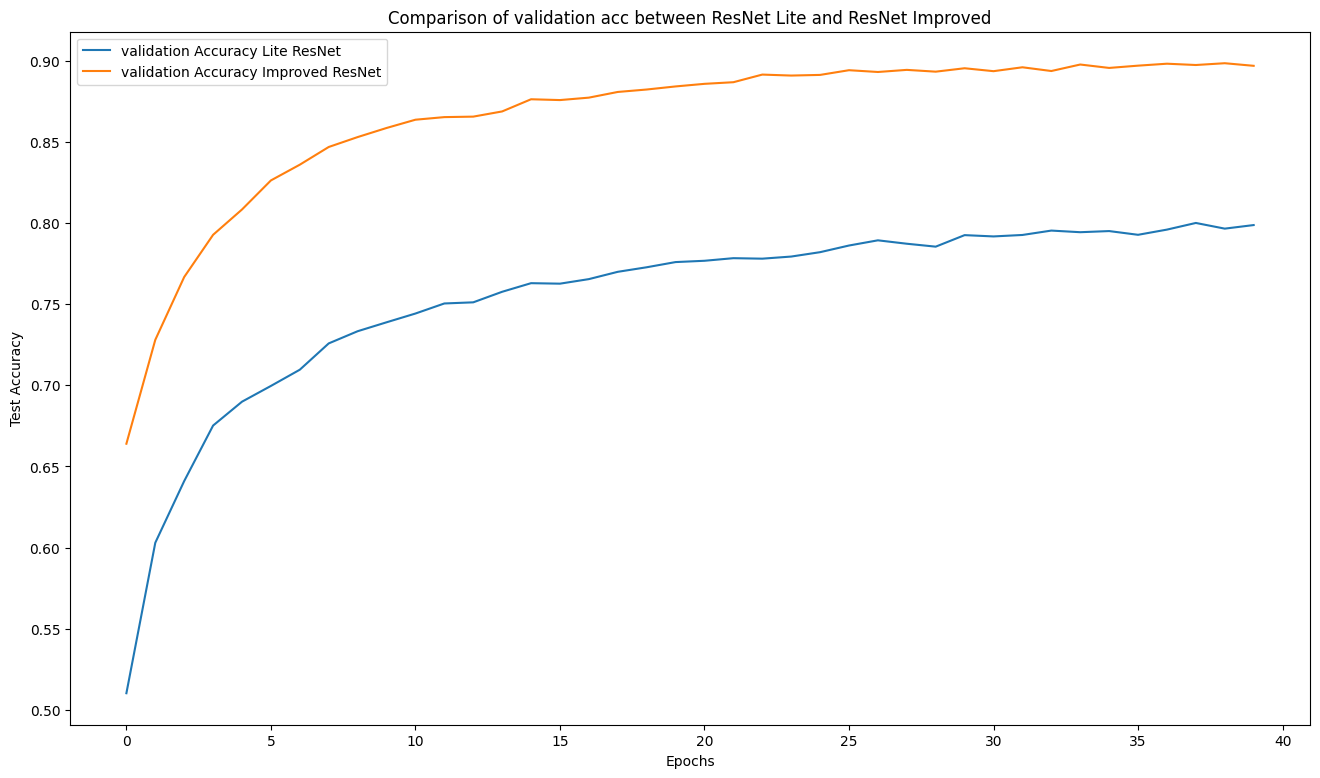

In [23]:
fig, ax = plt.subplots(figsize=(16,9))
plt.title('Comparison of validation acc between ResNet Lite and ResNet Improved')
plt.plot(acc_va_lite, label='validation Accuracy Lite ResNet')
plt.plot(acc_va_Improv, label='validation Accuracy Improved ResNet')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.show()